In [6]:
## Load packages for all chapter
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [7]:
## import data
chap_2_file = "./data/pbp_py_chap_2.csv"

if os.path.isfile(chap_2_file):
    pbp_py = pd.read_csv(chap_2_file, low_memory=False)
else:
    seasons = range(2016, 2023 + 1)
    pbp_py = nfl.import_pbp_data(seasons)
    pbp_py.to_csv(chap_2_file)

In [11]:
## extract passing data
pbp_py_p = pbp_py.query("play_type == 'pass' & air_yards.notnull()").reset_index()

## create filtering criteria
pbp_py_p["pass_length_air_yards"] = np.where(
    pbp_py_p["air_yards"] >= 20, "long", "short"
)

## replace missing values
pbp_py_p["passing_yards"] = np.where(
    pbp_py_p["passing_yards"].isnull(), 0, pbp_py_p["passing_yards"]
)

## describe passing data
pbp_py_p["passing_yards"].describe()

## summarize by pass length
pbp_py_p.query('pass_length_air_yards == "short"')["passing_yards"].describe()

## filter and only look at long passes
pbp_py_p.query('pass_length_air_yards == "long"')["passing_yards"].describe()

## look at EPA for short passes
pbp_py_p.query('pass_length_air_yards == "short"')["epa"].describe()

## look at EPA for long passes
pbp_py_p.query('pass_length_air_yards == "long"')["epa"].describe()

count    15521.000000
mean         0.382539
std          2.186034
min        -10.477922
25%         -0.827517
50%         -0.465127
75%          2.136195
max          8.789743
Name: epa, dtype: float64

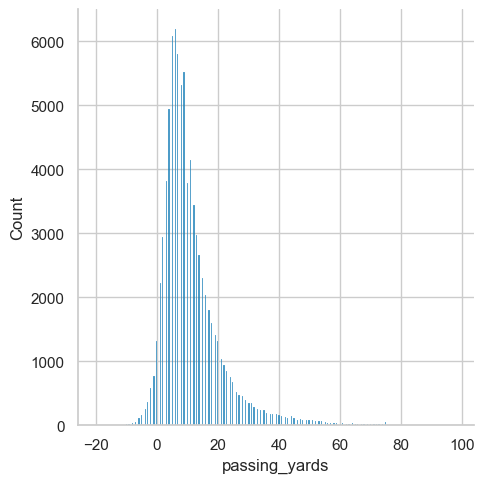

In [12]:
## histograms
sns.displot(data=pbp_py, x="passing_yards")
plt.show()

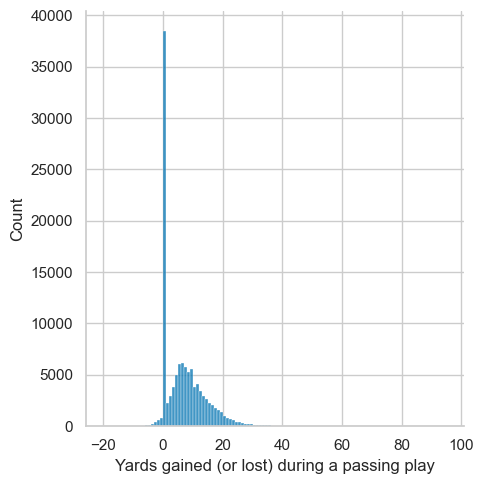

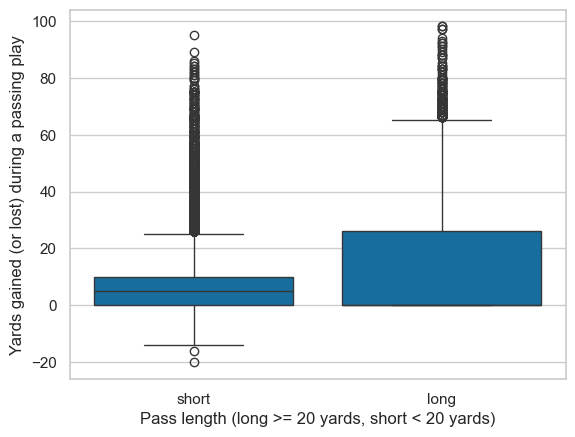

In [13]:
## set plot setting for rest of chapter
sns.set_theme(style="whitegrid", palette="colorblind")

## filter out for short passes
pbp_py_p_short = pbp_py_p.query('pass_length_air_yards == "short"')

## Clean up the plot
# Plot, change labels, and then show the output
pbp_py_hist_short = sns.displot(data=pbp_py_p_short, binwidth=1, x="passing_yards")
pbp_py_hist_short.set_axis_labels(
    "Yards gained (or lost) during a passing play", "Count"
)
plt.show()

## pass boxplot Python
pass_boxplot = sns.boxplot(data=pbp_py_p, x="pass_length_air_yards", y="passing_yards")
pass_boxplot.set(
    xlabel="Pass length (long >= 20 yards, short < 20 yards)",
    ylabel="Yards gained (or lost) during a passing play",
)
plt.show()

   pass_length_air_yards     passer  season        ypa   ypa_last
47                  long  A.Rodgers    2019  12.092593  12.011628
49                  long  A.Rodgers    2020  16.097826  12.092593
51                  long  A.Rodgers    2021  14.302632  16.097826
53                  long  A.Rodgers    2022  10.312500  14.302632
45                 short  A.Rodgers    2017   6.041475   6.693523
46                 short  A.Rodgers    2018   6.697446   6.041475
48                 short  A.Rodgers    2019   6.207224   6.697446
50                 short  A.Rodgers    2020   6.718447   6.207224
52                 short  A.Rodgers    2021   6.777083   6.718447
54                 short  A.Rodgers    2022   6.239130   6.777083
0                   long    T.Brady    2017  13.264706  15.768116
2                   long    T.Brady    2018  10.232877  13.264706
4                   long    T.Brady    2019  10.828571  10.232877
6                   long    T.Brady    2020  12.252101  10.828571
8         

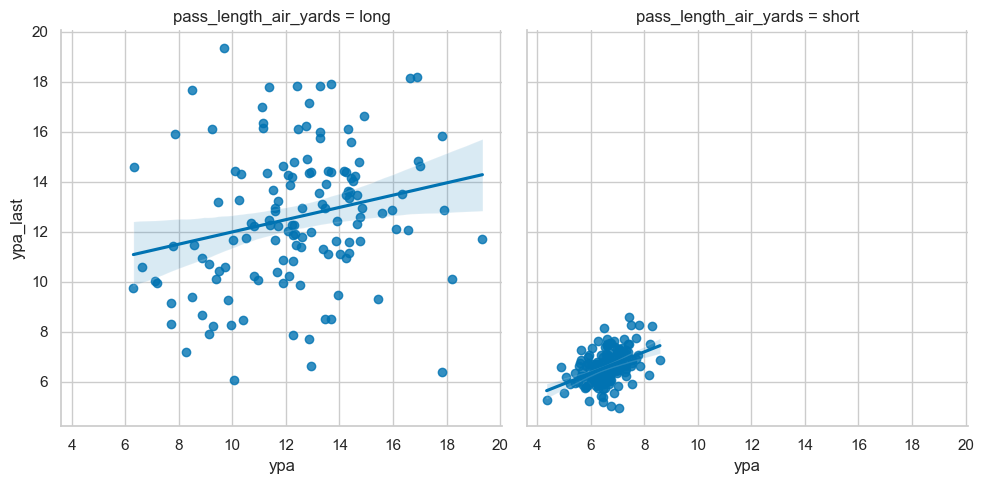

,passer_id,passer,ypa
116,00-0029263,R.Wilson,15.597403
14,00-0020531,D.Brees,14.903226
205,00-0033077,D.Prescott,14.771930
214,00-0033106,J.Goff,14.445946
35,00-0022942,P.Rivers,14.357143
157,00-0031280,D.Carr,14.339286
188,00-0032268,M.Mariota,13.941176
64,00-0026143,M.Ryan,13.465753
193,00-0032950,C.Wentz,13.222222
24,00-0022803,E.Manning,12.941176


In [14]:
## player-level stability
## aggregate data
pbp_py_p_s = pbp_py_p.groupby(["passer_id", "passer", "season"]).agg(
    {"passing_yards": ["mean", "count"]}
)

## reformat columns
pbp_py_p_s.columns = list(map("_".join, pbp_py_p_s.columns.values))

## rename columns
pbp_py_p_s.rename(
    columns={"passing_yards_mean": "ypa", "passing_yards_count": "n"}, inplace=True
)

## look at results
## you will likely want to not include .head() to see all results
pbp_py_p_s.sort_values(by=["ypa"], ascending=False).head()

## select at players with more than 100 yards
pbp_py_p_s_100 = pbp_py_p_s.query("n >= 100").sort_values(by=["ypa"], ascending=False)

## Look at results
pbp_py_p_s_100.head()

## calculate at play-by-play passer data by season and pass length
pbp_py_p_s_pl = pbp_py_p.groupby(
    ["passer_id", "passer", "season", "pass_length_air_yards"]
).agg({"passing_yards": ["mean", "count"]})

## format and rename columns
pbp_py_p_s_pl.columns = list(map("_".join, pbp_py_p_s_pl.columns.values))
pbp_py_p_s_pl.rename(
    columns={"passing_yards_mean": "ypa", "passing_yards_count": "n"}, inplace=True
)

## reset pandas index
pbp_py_p_s_pl.reset_index(inplace=True)

## select only short passing data
q_value = (
    "(n >= 100 & "
    + 'pass_length_air_yards == "short") | '
    + "(n >= 30 & "
    + 'pass_length_air_yards == "long")'
)
pbp_py_p_s_pl = pbp_py_p_s_pl.query(q_value).reset_index()

## only save select columns
cols_save = ["passer_id", "passer", "season", "pass_length_air_yards", "ypa"]
air_yards_py = pbp_py_p_s_pl[cols_save].copy()

## create lag data
air_yards_lag_py = air_yards_py.copy()
air_yards_lag_py["season"] += 1
air_yards_lag_py.rename(columns={"ypa": "ypa_last"}, inplace=True)

## merge lag data back in
pbp_py_p_s_pl = air_yards_py.merge(
    air_yards_lag_py,
    how="inner",
    on=["passer_id", "passer", "season", "pass_length_air_yards"],
)

## Look at merged data for two passers
print(
    pbp_py_p_s_pl[["pass_length_air_yards", "passer", "season", "ypa", "ypa_last"]]
    .query('passer == "T.Brady" | passer == "A.Rodgers"')
    .sort_values(["passer", "pass_length_air_yards", "season"])
    .to_string()
)

## Look at the info the dataframe
pbp_py_p_s_pl.info()

## see number of quarterbacks
len(pbp_py_p_s_pl.passer_id.unique())

## plot scatterplot with Python
sns.lmplot(data=pbp_py_p_s_pl, x="ypa", y="ypa_last", col="pass_length_air_yards")
plt.show()

## Look at correlation in Python
pbp_py_p_s_pl.query("ypa.notnull() & ypa_last.notnull()").groupby(
    "pass_length_air_yards"
)[["ypa", "ypa_last"]].corr()

## 2017 YPA leaderboard
pbp_py_p_s_pl.query('pass_length_air_yards == "long" & season == 2017')[
    ["passer_id", "passer", "ypa"]
].sort_values(["ypa"], ascending=False).head(10)

## 2018 YPA leaderboard
pbp_py_p_s_pl.query('pass_length_air_yards == "long" & season == 2018')[
    ["passer_id", "passer", "ypa"]
].sort_values(["ypa"], ascending=False).head(10)
